# 비지도학습 군집화 테스트

###  "사용 데이터 : 장르별 베스트셀러 리뷰 모음"
### 최적 토픽 갯수 테스트

### 조건
    * 각각의 ISBN끼리 리뷰를 합쳐서 테스트
    * 명사

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [2]:
import konlpy
from konlpy.tag import Okt

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


# 데이터 전처리

## 도서 리뷰 추가

In [4]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## <전처리>

In [5]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

### ISBN을 기준으로 리뷰를 모은 뒤 재조합

## <토큰화>

#### 분류 테스트 

In [6]:
okt = Okt()

----

### 기존 데이터 가져오기

In [7]:
# 불러오기
import pickle

book_morphs_with_isbn_pos_non_stopword = []
with open('data/detail_bestbook_unit_isbn_with_isbn_pos_non_stopword.txt', 'rb') as lf:
    book_morphs_with_isbn_pos_non_stopword = pickle.load(lf)
    
print(book_morphs_with_isbn_pos_non_stopword[0])

[9788959752195, [('내', 'Noun'), ('가제', 'Noun'), ('일', 'Noun'), ('좋아하다', 'Adjective'), ('책', 'Noun'), ('이', 'Noun'), ('당', 'Noun'), ('6', 'Number')]]


In [8]:
print(len(book_morphs_with_isbn_pos_non_stopword))
print(book_morphs_with_isbn_pos_non_stopword[2])

42559
[9791127420949, [('덕분', 'Noun'), ('에', 'Josa'), ('귀엽다', 'Adjective'), ('SD', 'Alpha'), ('를', 'Noun'), ('그릴', 'Noun'), ('수', 'Noun'), ('있다', 'Adjective'), ('되어다', 'Verb'), ('너무', 'Adverb'), ('기쁘다', 'Adjective'), ('별', 'Noun'), ('5', 'Number'), ('개', 'Noun'), ('로', 'Noun'), ('도', 'Noun'), ('사실', 'Noun'), ('모자라다', 'Verb'), ('정도', 'Noun'), ('로', 'Noun'), ('좋다', 'Adjective'), ('책', 'Noun'), ('채색', 'Noun'), ('이', 'Noun'), ('없다', 'Adjective'), ('게', 'Noun'), ('좀', 'Noun'), ('아쉽다', 'Adjective'), ('채색', 'Noun'), ('책', 'Noun'), ('이', 'Noun'), ('아니다', 'Adjective'), ('별', 'Noun'), ('기대', 'Noun'), ('안', 'Noun'), ('하다', 'Verb'), ('생각', 'Noun'), ('보다', 'Verb'), ('내용', 'Noun'), ('이', 'Noun'), ('알차다', 'Adjective'), ('두고두고', 'Noun'), ('볼', 'Noun'), ('것', 'Noun'), ('같다', 'Adjective')]]


In [9]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','을','이라',
             '라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있','죠','고','니','로','있','같',
             '어서','어요','는데','습니다','면서','많이','마','더','그렇다','의','당','좀','책','안','볼','게','안','정말','듯','이제야','여','요','게다가','같다',
            '임','로서','이제','만','인','붙이','그','저','수','가제','부터','닷','저희','적','알','쉬','못','꼭','살','제','권','제','분','나','내', '진작', '전', '뿐'
            , '대한','대해','책','좋다']

In [10]:
######### 태깅한 데이터 중에서 명사 +불용어 처리

book_train_nouns = []
book_train_isbn = []
for (isbn, test) in book_morphs_with_isbn_pos_non_stopword :
    tts = [(word,pos) for (word,pos) in test if not word in stopwords] #불용어 처리
    na = [word for (word,pos) in tts if pos in 'Noun'] # 명사만 저장

    if na : 
        book_train_nouns.append(na)
        book_train_isbn.append(isbn)

print('**********************END***************************')
print(len(book_train_nouns))
print(len(book_train_isbn))

**********************END***************************
42337
42337


In [11]:
for i in range(0,5) :
#     print(book_morphs_with_isbn_pos_non_stopword[i])
    print(book_train_nouns[i])

['일']
['처음', '제목', '보고', '예상', '스토리', '완전', '신간', '홀린', '장바구니', '사서', '맘', '사서', '걸', '조금', '여자', '이야기']
['덕분', '그릴', '별', '개', '사실', '정도', '채색', '채색', '별', '기대', '생각', '내용', '두고두고']
['구매', '쭉', '지리', '여행', '여행', '가기']
['요가', '궁극', '의미', '요가', '수행자', '위', '메시지', '방법', '과정', '자세', '설명', '알다', '정리', '매우', '서적', '요가', '공부', '위해', '구입', '공부', '도움', '요가', '교과서', '말', '요가', '백과사전', '식', '명작', '설명', '그림', '첨부', '재미', '실제', '응용', '위', '참고서', '아헹', '선생님', '요가', '알라딘', '쿠폰', '무료', '배송', '보아', '요가', '교과서', '최고', '요가', '입문', '무리']


----

# 정수 인코딩과 단어 집합 만들기

(인코딩값, 빈도수)

In [13]:
from gensim import corpora


dictionary = corpora.Dictionary(book_train_nouns)
corpus = [dictionary.doc2bow(text) for text in book_train_nouns]

print('END')

END


In [14]:
print(len(book_train_nouns))
print(len(dictionary))
print(len(corpus))

42337
52744
42337


In [18]:
print(corpus[13578])

[(0, 5), (1, 1), (8, 2), (10, 2), (12, 8), (14, 1), (16, 1), (19, 9), (20, 1), (21, 1), (22, 2), (24, 10), (32, 3), (35, 3), (38, 2), (39, 9), (40, 2), (45, 2), (48, 1), (51, 1), (56, 6), (59, 2), (60, 5), (62, 2), (63, 1), (64, 1), (66, 1), (68, 1), (69, 1), (78, 1), (81, 1), (85, 3), (96, 12), (105, 1), (122, 1), (124, 1), (129, 1), (131, 1), (134, 2), (138, 1), (144, 1), (149, 3), (168, 1), (169, 1), (172, 1), (177, 1), (192, 1), (194, 6), (195, 4), (204, 1), (209, 2), (212, 6), (217, 1), (220, 1), (221, 1), (225, 1), (227, 2), (228, 1), (230, 1), (232, 1), (233, 7), (236, 4), (238, 1), (240, 2), (254, 1), (255, 1), (257, 1), (264, 1), (268, 2), (274, 1), (289, 1), (293, 1), (300, 5), (303, 2), (309, 1), (315, 1), (318, 2), (324, 2), (331, 1), (332, 1), (334, 1), (341, 1), (349, 1), (350, 1), (357, 2), (359, 1), (361, 5), (364, 2), (371, 2), (382, 5), (398, 2), (400, 5), (401, 2), (402, 1), (404, 2), (410, 1), (414, 1), (416, 1), (417, 2), (419, 1), (425, 1), (428, 1), (435, 1), (43

In [19]:
print(dictionary[24])
print(dictionary[973])

생각
인문학


----

## 모델 평가 & 토픽 최적화


In [20]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 

coherence_values=[]

for i in range(2,20) : 
    ldamodel = LdaModel(corpus,num_topics=i,id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel,texts=book_train_nouns,dictionary=dictionary) # ,topn=10
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

In [21]:
print('coherence_values : ',coherence_values)

coherence_values :  [0.3335590065699178, 0.36206178927454885, 0.36192906921198026, 0.3940860685882329, 0.39975814226295925, 0.3924189675019627, 0.37886255701445826, 0.4107700448487242, 0.41221553803543703, 0.4068027851220238, 0.4035838613445161, 0.4181815801189724, 0.38800799432036764, 0.3976145729774292, 0.4230040499003889, 0.42969016289399703, 0.4290695210535149, 0.4142146756830308]


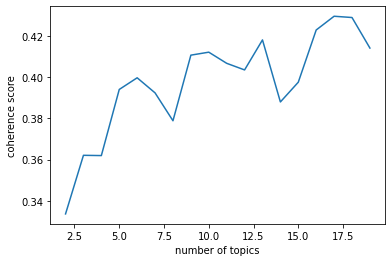

In [22]:
x=range(2,20,1)
plt.plot(x,coherence_values)
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.show()

In [23]:
perplexity_values=[]

for i in range(2,20) :
    ldamodel = LdaModel(corpus,num_topics=i,id2word=dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

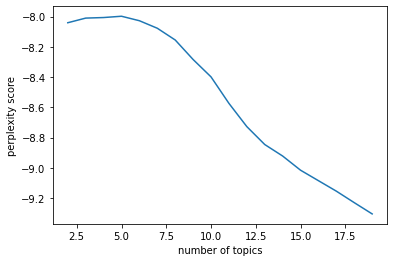

In [24]:
x=range(2,20)
plt.plot(x,perplexity_values)
plt.xlabel('number of topics')
plt.ylabel('perplexity score')
plt.show()

In [25]:
print('perplexity_values : ',perplexity_values)

perplexity_values :  [-8.04114320745636, -8.010478289405212, -8.006775627189121, -7.998217133609825, -8.027916364910226, -8.077582770058026, -8.155216156049642, -8.284198134275849, -8.399049894054562, -8.574024409963615, -8.727739422519905, -8.84601891742492, -8.92207285827926, -9.015782115247506, -9.085078035560647, -9.154346146639336, -9.230261315613516, -9.304700114266323]


#### (개인적인 생각 : topics 17개)

----

### Topics =  , Passes 테스트

In [29]:
coherence_values_passes=[]

for i in range(5,20) : 
    ldamodel = LdaModel(corpus,num_topics=17,id2word=dictionary,passes=i)
    coherence_model_lda = CoherenceModel(model=ldamodel,texts=book_train_nouns,dictionary=dictionary) # ,topn=10
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values_passes.append(coherence_lda)

In [30]:
print('coherence_values_passes : ',coherence_values_passes)

coherence_values_passes :  [0.4647623522546778, 0.44956028491569183, 0.4524173487879958, 0.4721200365799536, 0.4611751776074261, 0.44889523685105664, 0.4535599541266481, 0.43962568507580907, 0.460184724689556, 0.45244020532606594, 0.4522450865159385, 0.4485214812946688, 0.4649391809736233, 0.44332496301129676, 0.444207159509287]


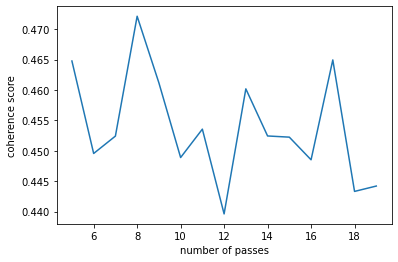

In [31]:
x=range(5,20)
plt.plot(x,coherence_values_passes)
plt.xlabel('number of passes')
plt.ylabel('coherence score')
plt.show()

#### (개인적인 생각 : passes는 8번 정도)

---

### 토픽 선정 및 시각화

In [32]:
ldamodel = LdaModel(corpus,
                    num_topics=17,
                    id2word=dictionary,
                    passes=8) # 감마를 어떻게 할까.... alpha
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.086*"영화" + 0.024*"원작" + 0.021*"나무" + 0.017*"보고" + 0.017*"음식" + 0.012*"베" + 0.011*"카" + 0.009*"미미" + 0.009*"게임" + 0.008*"애니메이션"')
(1, '0.025*"설명" + 0.015*"요리" + 0.013*"도움" + 0.011*"사진" + 0.011*"집" + 0.010*"레시피" + 0.010*"내용" + 0.010*"정리" + 0.009*"추천" + 0.009*"하나"')
(2, '0.105*"여행" + 0.033*"투자" + 0.028*"돈" + 0.027*"코로나" + 0.025*"지도" + 0.021*"주식" + 0.019*"곳" + 0.019*"부자" + 0.016*"부동산" + 0.014*"정보"')
(3, '0.023*"생각" + 0.023*"도움" + 0.021*"사람" + 0.017*"방법" + 0.016*"내용" + 0.015*"알다" + 0.015*"공감" + 0.011*"법" + 0.009*"말" + 0.009*"추천"')
(4, '0.060*"공부" + 0.034*"영어" + 0.025*"문제" + 0.020*"교재" + 0.017*"단어" + 0.014*"학습" + 0.014*"수학" + 0.014*"도움" + 0.010*"구성" + 0.010*"개념"')
(5, '0.028*"이해" + 0.024*"내용" + 0.021*"과학" + 0.020*"설명" + 0.015*"철학" + 0.011*"저자" + 0.011*"지식" + 0.010*"생각" + 0.009*"알다" + 0.009*"추천"')
(6, '0.077*"역사" + 0.036*"고전" + 0.017*"이야기" + 0.015*"한국" + 0.013*"전쟁" + 0.013*"시대" + 0.011*"알다" + 0.011*"우리" + 0.010*"그리스" + 0.009*"기대"')
(7, '0.040*"사랑" + 0.019*"다시" + 0.019*"마음" + 0.018*"감동"

In [33]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [34]:
for i, topic_list in enumerate(ldamodel[corpus]):
    if i==20:
        break
#     print(i,'번째 문서의 topic 비율은',topic_list)
    print(book_train_isbn[i],'의 topic 비율은',topic_list)

9788959752195 의 topic 비율은 [(0, 0.029412305), (1, 0.029412305), (2, 0.029412305), (3, 0.02941233), (4, 0.029412309), (5, 0.029412305), (6, 0.029412305), (7, 0.029412312), (8, 0.02941231), (9, 0.029412305), (10, 0.029412316), (11, 0.029412305), (12, 0.02941231), (13, 0.029412312), (14, 0.52940303), (15, 0.02941231), (16, 0.029412309)]
9791136202772 의 topic 비율은 [(13, 0.2890939), (15, 0.65899414)]
9791127420949 의 topic 비율은 [(1, 0.93276423)]
9791164383252 의 topic 비율은 [(2, 0.49659327), (8, 0.1529593), (15, 0.23277767)]
9788995797020 의 topic 비율은 [(1, 0.08890771), (3, 0.13616237), (4, 0.48972666), (5, 0.17282951), (15, 0.098244704)]
9788978495516 의 topic 비율은 [(1, 0.32277372), (3, 0.5299162)]
9788965912606 의 topic 비율은 [(4, 0.33136693), (6, 0.3925225), (8, 0.06201857), (16, 0.1716023)]
9788967354398 의 topic 비율은 [(3, 0.40871373), (9, 0.07312216), (10, 0.18700139), (14, 0.2150102), (15, 0.08996148)]
9788975611933 의 topic 비율은 [(0, 0.05882353), (1, 0.05882353), (2, 0.05882353), (3, 0.05882353), (4, 

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# 모델 저장
model_name = 'model/nouns_17topics_8passes'
ldamodel.save(model_name)

d:\project02\field-team4_test\machine_learning\web_scraping\venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
